#### Réalisé par :

AIT AMARA Mohamed, 181831072170

BOUROUINA Rania, 181831052716

CHIBANE Ilies, 181831072041

HAMMAL Ayoub, 181831048403

In [1]:
import re
import os
from collections import Counter

import numpy as np

import matplotlib.pyplot as plt

import nltk

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

Fixing the random seed

In [2]:
seed = 42
def set_seed(self, seed=42):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    np.random.seed(seed)
set_seed(seed)

## Data preparation

Some files are in latin-1 encoding so we are converting them to utf-8

In [3]:
for filename in os.listdir(os.path.abspath("data/spam")):
    try:
        with open(os.path.join("data/spam", filename), "r", encoding="utf-8") as file:
            content = file.read()
    except UnicodeDecodeError:
        with open(os.path.join("data/spam", filename), "r", encoding="latin-1") as file:
            content = file.read()
        with open(os.path.join("data/spam", filename), "w", encoding="utf-8") as file:
            file.write(content)
for filename in os.listdir(os.path.abspath("data/ham")):
    try:
        with open(os.path.join("data/ham", filename), "r", encoding="utf-8") as file:
            content = file.read()
    except UnicodeDecodeError:
        with open(os.path.join("data/ham", filename), "r", encoding="latin-1") as file:
            content = file.read()
        with open(os.path.join("data/ham", filename), "w", encoding="utf-8") as file:
            file.write(content)

The preprocessing function that handles tokenization and stemming

In [4]:
def preprocessing(file):
    file.seek(0)
    
    # strip metadata
    while file.readline() != '\n':
        pass
    
    # lower case
    mail = file.read().lower()
    
    # html
    mail = re.sub('<[^<>]+>', ' ', mail)
    
    # dollars
    mail = mail.replace('$', " dollar ")
    
    # urls
    mail = re.sub(r'(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*', 
                  "httpaddr",
                  mail)
    
    # emails
    mail = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', "emailaddr", mail)
    
    # numbers
    mail = re.sub(r'\d+', "number", mail)
    
    # tokenize
    tokenizer = nltk.tokenize.TreebankWordTokenizer()
    tokens = tokenizer.tokenize(mail)
    
    # stemming
    stemmer = nltk.stem.snowball.SnowballStemmer("english")
    tokens = [stemmer.stem(token) for token in tokens if token.isalpha()]
    
    return tokens

The creation of a vocabulary : we go through all the files and collect the different tokens

In [5]:
raw_vocab = []
for filename in os.listdir(os.path.abspath("data/spam")):
    with open(os.path.join("data/spam", filename), "r", encoding="utf-8") as file_content:
        tokens = preprocessing(file_content)
        raw_vocab += tokens
for filename in os.listdir(os.path.abspath("data/ham")):
    with open(os.path.join("data/ham", filename), "r", encoding="utf-8") as file_content:
        tokens = preprocessing(file_content)
        raw_vocab += tokens

nltk.download('stopwords', quiet=True)
stopwords = nltk.corpus.stopwords.words('english')
raw_vocab = [x for x in raw_vocab if x not in stopwords]
print("There are", len(raw_vocab), "tokens in the raw vocabulary")

There are 586079 tokens in the raw vocabulary


Removing the less frequent words, and keeping only the 5 000 most frequent words

In [6]:
vocabulary_size = 5000
bag_of_words = Counter(raw_vocab)
vocab = [x[0] for x in bag_of_words.most_common(vocabulary_size)]
print("There are", len(vocab), "different tokens after cleaning")

There are 5000 different tokens after cleaning


We map each token to an integer from 1 to 5000, whereas 0 represent a pading token

In [7]:
word_to_index = {}
index_to_word = {}
for index, word in enumerate(vocab):
    word_to_index[word] = index + 1
    index_to_word[index + 1] = word

Transforms a list of tokens to a list of integers

In [8]:
def encoding_tokens(tokens):
    return [word_to_index.get(word, 0) for word in tokens if word in word_to_index]

In [9]:
def transform(file):
    tokens = preprocessing(file)
    encoded_tokens = encoding_tokens(tokens)
    return encoded_tokens

The creation of a dataset class that load the files and handle the transformation.

Loading files can be done on demande, but since we have few data and models with no heavy computations, loading data on the fly would bottle neck the training, so we preload all the data at once.

In [10]:
class MailDataset(Dataset):
    def __init__(self, 
            pos_files,
            neg_files,
            transform=transform,
            positive_class_dir="data/spam",
            negative_class_dir="data/ham"):
        
        self.positive_class_dir = positive_class_dir
        self.negative_class_dir = negative_class_dir
        
        self.pos_files = pos_files
        self.neg_files = neg_files
        
        self.transform = transform
        
        self.mails = []
        for file in self.pos_files:
            mail_path = os.path.join(self.positive_class_dir, file)
            label = 1
            with open(mail_path, "r", encoding="utf-8") as file:
                mail = [0] + transform(file)
            self.mails.append((mail, label))
        for file in self.neg_files:
            mail_path = os.path.join(self.negative_class_dir, file)
            label = 0
            with open(mail_path, "r", encoding="utf-8") as file:
                mail = [0] + transform(file)
            self.mails.append((mail, label))
        
    def __len__(self):
        return len(self.mails)
    
    def __getitem__(self, idx):
        mail, label = self.mails[idx]
        return torch.unsqueeze(torch.as_tensor(mail), dim=-1).float(), torch.as_tensor(label).float()

Creating test and train sets by randomly splitting files from both spam and ham folder and assigning them to either test or train set.

In [11]:
def create_train_test_dataset(
        test_ratio=0.3,
        positive_class_dir="data/spam",
        negative_class_dir="data/ham"):
    
    pos_files = os.listdir(os.path.abspath(positive_class_dir))
    neg_files = os.listdir(os.path.abspath(negative_class_dir))
    
    shuffled_pos_indices = np.random.permutation(len(pos_files))
    shuffled_neg_indices = np.random.permutation(len(neg_files))

    pos_test_set_size = int(len(pos_files) * test_ratio)
    neg_test_set_size = int(len(neg_files) * test_ratio)
    
    pos_train_indices = shuffled_pos_indices[pos_test_set_size:]
    pos_test_indices = shuffled_pos_indices[:pos_test_set_size]
    
    neg_train_indices = shuffled_neg_indices[neg_test_set_size:]
    neg_test_indices = shuffled_neg_indices[:neg_test_set_size]
    
    pos_train_files = [pos_files[i] for i in pos_train_indices]
    neg_train_files = [neg_files[i] for i in neg_train_indices]
    
    pos_test_files = [pos_files[i] for i in pos_test_indices]
    neg_test_files = [neg_files[i] for i in neg_test_indices]
    
    train_dataset = MailDataset(pos_train_files, neg_train_files)
    test_dataset = MailDataset(pos_test_files, neg_test_files)
    
    return train_dataset, test_dataset

Collate functions are used with pytorch dataloader to make batches uniform

In [12]:
def pad_collate(batch):
    X = [item[0] for item in batch]
    y = [item[1] for item in batch]
    X_pad = pad_sequence(X, batch_first=True)
    return X_pad, torch.as_tensor(y).view(-1, 1)

In [13]:
def bin_bow_collate(batch):
    X = [item[0] for item in batch]
    y = [item[1] for item in batch]
    
    bow = torch.zeros((len(X), vocabulary_size))
    
    for i, email in enumerate(X):
        for word_index in email:
            if (word_index.int().item() > 0):
                bow[i, word_index.int().item() - 1] = 1
    return bow, torch.as_tensor(y).view(-1, 1)

In [14]:
def bow_collate(batch):
    X = [item[0] for item in batch]
    y = [item[1] for item in batch]
    
    bow = torch.zeros((len(X), vocabulary_size))
    
    for i, email in enumerate(X):
        for word_index in email:
            if (word_index.int().item() > 0):
                bow[i, word_index.int().item() - 1] += 1
    return bow, torch.as_tensor(y).view(-1, 1)

## Model selection

In [15]:
train_dataset, test_dataset = create_train_test_dataset()

Visuatlization of the words of the training dataset

Text(0.5, 1.0, 'difference histogram')

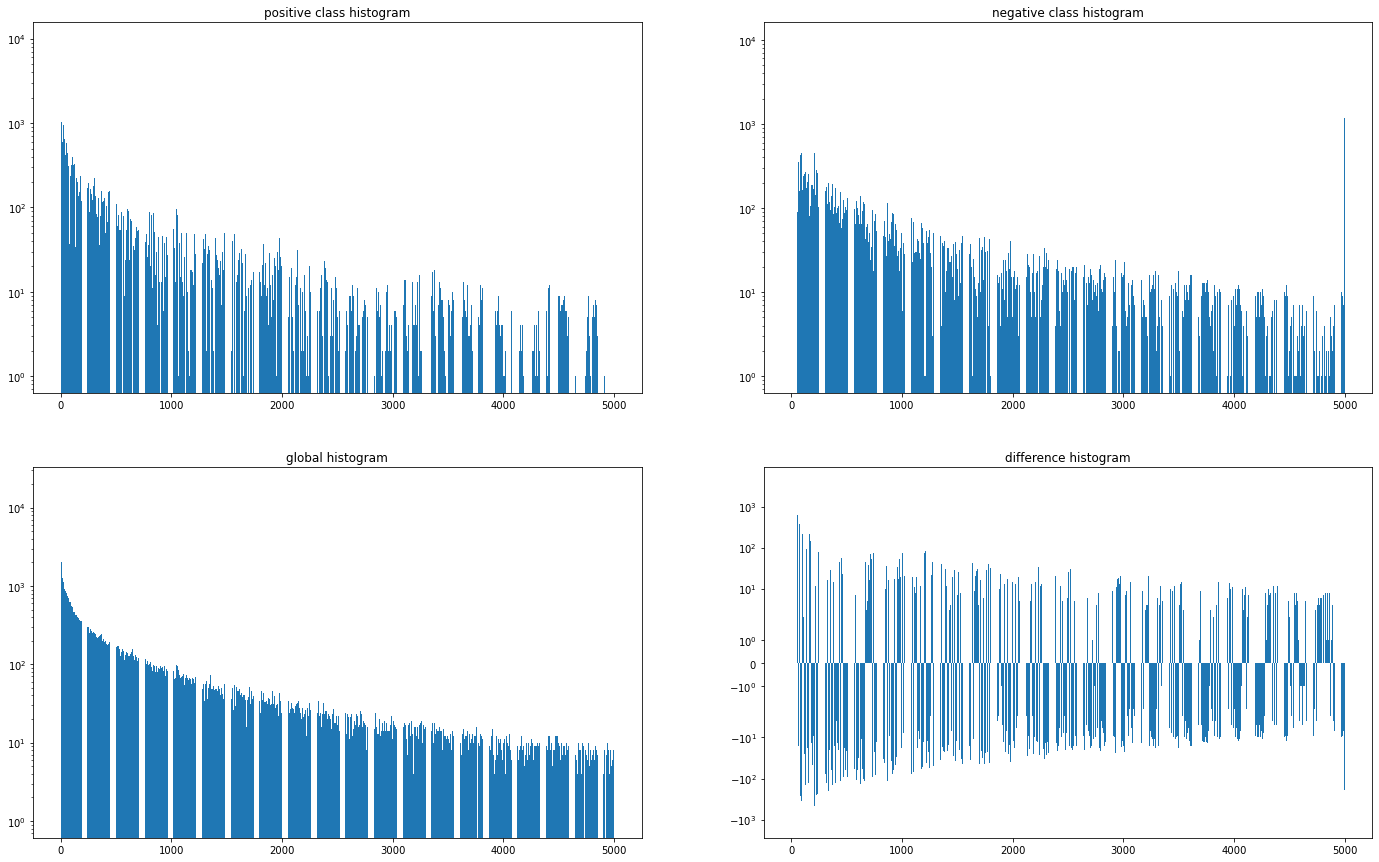

In [16]:
# plotting words histogram on logarithmic scale
hist = np.zeros((vocabulary_size,))
pos_hist = np.zeros((vocabulary_size,))
neg_hist = np.zeros((vocabulary_size,))
for x, y in train_dataset:
    for word in x:
        hist[int(word.item()) - 1] += 1
        if y == 0:
            neg_hist[int(word.item()) - 1] += 1
        else:
            pos_hist[int(word.item()) - 1] += 1

plt.figure(figsize=(24, 15))


plt.subplot(2, 2, 1)
plt.bar(list(range(vocabulary_size)), pos_hist)
plt.yscale('log')
plt.title("positive class histogram")

plt.subplot(2, 2, 2)
plt.bar(list(range(vocabulary_size)), neg_hist)
plt.yscale('log')
plt.title("negative class histogram")

plt.subplot(2, 2, 3)
plt.bar(list(range(vocabulary_size)), hist)
plt.yscale('log')
plt.title("global histogram")

plt.subplot(2, 2, 4)
plt.bar(list(range(vocabulary_size)), pos_hist - neg_hist)
plt.yscale("symlog")
plt.title("difference histogram")

We observe from the last plot that there is clear contrast between the two classes

### Deep model

#### LSTM

The following wrapper class allow us to encapsulate training logic and loss tracking

In [17]:
class Wrapper:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        self.model.to(self.device)
        
        self.train_loader = None
        self.val_loader = None
        
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0
        
        self.best_loss = np.Inf
        self.best_state_dict = None
        self.best_loss_epoch = 0

    def set_loaders(self, train_loader, val_loader=None):
        self.train_loader = train_loader
        self.val_loader = val_loader
        
    def train_step(self, X, y):
        self.model.train()
        
        yhat = self.model(X)
        
        loss = self.loss_fn(yhat, y)
        loss.backward()
        
        self.optimizer.step()
        self.optimizer.zero_grad()
        
        return loss.item()
    
    def val_step(self, X, y):
        self.model.eval()
        
        yhat = self.model(X)
        
        loss = self.loss_fn(yhat, y)
        
        return loss.item()
    
    def _mini_batch(self, validation=False):
        if validation:
            data_loader = self.val_loader
            step = self.val_step
        else:
            data_loader = self.train_loader
            step = self.train_step
            
        if data_loader is None:
            return None
        
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)
 
            mini_batch_loss = step(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)
 
        loss = np.mean(mini_batch_losses)
    
        return loss
    
    def train(self, n_epochs):
        for epoch in range(n_epochs):
    
            self.total_epochs += 1

            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            with torch.no_grad():

                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)
    
            scalars = {'training': loss}
            if val_loss is not None:
                scalars.update({'validation': val_loss})
            
            print("epoch: {0} | training loss: {1:.2f} | validation loss: {2:.2f}"
                  .format(epoch, scalars["training"], scalars["validation"]))
            
            if val_loss < self.best_loss:
                self.best_loss = val_loss
                self.best_state_dict = self.model.state_dict()
                self.best_loss_epoch = epoch
        
        self.model.load_state_dict(self.best_state_dict)
                
    def predict(self, x):
        self.model.eval()
        with torch.no_grad():
            y_hat_tensor = torch.sigmoid(self.model(x.to(self.device)))
        self.model.train()
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        ymin = min(min(self.losses), min(self.val_losses))
        ymax = max(max(self.losses), max(self.val_losses))
        plt.vlines(self.best_loss_epoch, ymin=ymin, ymax=ymax, colors='g', linestyles='--', label='Best loss')
        plt.plot(self.losses, label='Training Loss', c='b')
        if self.val_loader:
            plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()

In [18]:
class LSTMModel(nn.Module):
    def __init__(self, n_features, hidden_dim, n_outputs):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.hidden = None
        self.cell = None
        self.rnn = nn.LSTM(self.n_features,
                                 self.hidden_dim,
                                 batch_first=True)
        self.classifier = nn.Linear(self.hidden_dim, self.n_outputs)

    def forward(self, X):
        batch_first_output, (self.hidden, self.cell) = \
                                            self.rnn(X)
        last_output = batch_first_output[:, -1]
        out = self.classifier(last_output)
        return out.view(-1, self.n_outputs)

In [19]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=pad_collate)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, collate_fn=pad_collate)

lstm_model = LSTMModel(n_features=1, hidden_dim=128, n_outputs=1)
optimizer = Adam(lstm_model.parameters())
loss_fn = nn.BCEWithLogitsLoss(reduction='mean')

lstm_wrapper = Wrapper(lstm_model, loss_fn, optimizer)

epoch: 0 | training loss: 0.69 | validation loss: 0.68
epoch: 1 | training loss: 0.69 | validation loss: 0.69
epoch: 2 | training loss: 0.69 | validation loss: 0.69
epoch: 3 | training loss: 0.69 | validation loss: 0.68
epoch: 4 | training loss: 0.69 | validation loss: 0.68
epoch: 5 | training loss: 0.69 | validation loss: 0.69
epoch: 6 | training loss: 0.69 | validation loss: 0.68
epoch: 7 | training loss: 0.68 | validation loss: 0.68
epoch: 8 | training loss: 0.68 | validation loss: 0.69
epoch: 9 | training loss: 0.68 | validation loss: 0.70
epoch: 10 | training loss: 0.68 | validation loss: 0.68
epoch: 11 | training loss: 0.68 | validation loss: 0.69
epoch: 12 | training loss: 0.68 | validation loss: 0.67
epoch: 13 | training loss: 0.68 | validation loss: 0.67
epoch: 14 | training loss: 0.68 | validation loss: 0.68
epoch: 15 | training loss: 0.67 | validation loss: 0.67
epoch: 16 | training loss: 0.67 | validation loss: 0.68
epoch: 17 | training loss: 0.67 | validation loss: 0.70
ep

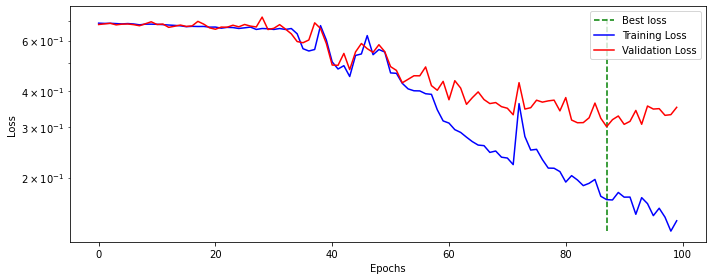

In [20]:
lstm_wrapper.set_loaders(train_dataloader, test_dataloader)
lstm_wrapper.train(n_epochs=100)
lstm_wrapper.plot_losses()

threshold is 0.2300172597169876 | accuracy is 83.13%


Text(0.5, 0, 'False positive rate')

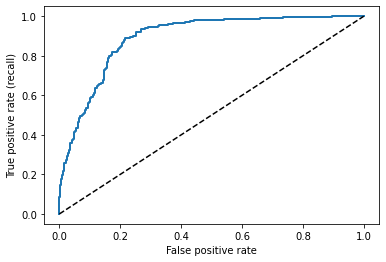

In [21]:
test_full = [(x[0], x[1].item()) for x in test_dataset]

test_prediction_scores, test_y = zip(*[(lstm_wrapper.predict(torch.unsqueeze(x, dim=0)).item(), y) \
                                       for x, y in list(test_full) if x.shape[0] > 0])


fpr, tpr, thresholds = roc_curve(test_y, test_prediction_scores)

gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
threshold = thresholds[ix]
test_prediction = np.asarray([ 1 if x > threshold else 0 for x in test_prediction_scores])
print("threshold is {0} | accuracy is {1:.2f}%"
      .format(threshold, (test_prediction==np.asarray(test_y)).mean() * 100))

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.ylabel("True positive rate (recall)")
plt.xlabel("False positive rate")

#### Linear

In [22]:
class LinearModel(nn.Module):
    def __init__(self, n_features, n_outputs):
        super(LinearModel, self).__init__()
        self.n_features = n_features
        self.n_outputs = n_outputs
        
        self.linear1 = nn.Linear(self.n_features, 128, bias=False)
        self.batchnorm1 = nn.BatchNorm1d(128)
        
        self.linear2 = nn.Linear(128, 64, bias=False)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
        self.linear3 = nn.Linear(64, self.n_outputs)
        
    def forward(self, X):
        out = self.linear1(X)
        out = self.batchnorm1(out)
        out = nn.functional.relu(out)
        
        out = self.linear2(out)
        out = self.batchnorm2(out)
        out = nn.functional.relu(out)
        
        out = self.linear3(out)
        
        return out.view(-1, self.n_outputs)

In [23]:
bin_bow_train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=bin_bow_collate)
bin_bow_test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, collate_fn=bin_bow_collate)

bin_linear_model = LinearModel(n_features=vocabulary_size, n_outputs=1)
optimizer = Adam(bin_linear_model.parameters())
loss_fn = nn.BCEWithLogitsLoss(reduction='mean')

bin_linear_wrapper = Wrapper(bin_linear_model, loss_fn, optimizer)

epoch: 0 | training loss: 0.21 | validation loss: 0.12
epoch: 1 | training loss: 0.07 | validation loss: 0.10
epoch: 2 | training loss: 0.06 | validation loss: 0.09
epoch: 3 | training loss: 0.04 | validation loss: 0.08
epoch: 4 | training loss: 0.04 | validation loss: 0.10
epoch: 5 | training loss: 0.05 | validation loss: 0.09
epoch: 6 | training loss: 0.05 | validation loss: 0.08
epoch: 7 | training loss: 0.03 | validation loss: 0.09
epoch: 8 | training loss: 0.02 | validation loss: 0.09
epoch: 9 | training loss: 0.03 | validation loss: 0.10
epoch: 10 | training loss: 0.03 | validation loss: 0.11
epoch: 11 | training loss: 0.02 | validation loss: 0.10
epoch: 12 | training loss: 0.02 | validation loss: 0.09
epoch: 13 | training loss: 0.02 | validation loss: 0.11
epoch: 14 | training loss: 0.03 | validation loss: 0.11
epoch: 15 | training loss: 0.02 | validation loss: 0.11
epoch: 16 | training loss: 0.01 | validation loss: 0.14
epoch: 17 | training loss: 0.01 | validation loss: 0.10
ep

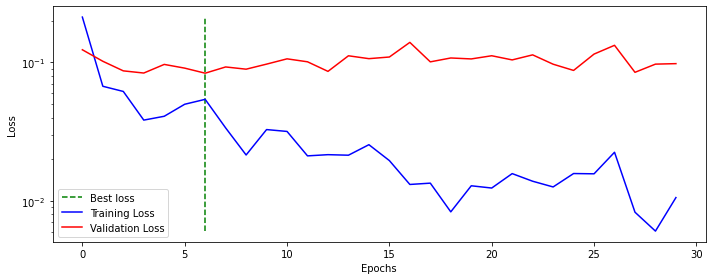

In [24]:
bin_linear_wrapper.set_loaders(bin_bow_train_dataloader, bin_bow_test_dataloader)
bin_linear_wrapper.train(n_epochs=30)
bin_linear_wrapper.plot_losses()

threshold is 0.6796258091926575 | accuracy is 97.37%


Text(0.5, 0, 'False positive rate')

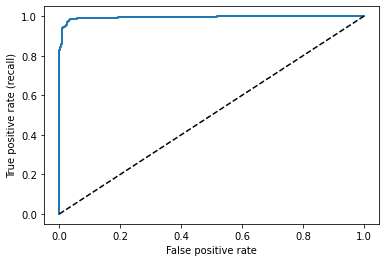

In [25]:
test_full = [bin_bow_collate([(x[0], x[1])]) for x in test_dataset]

test_prediction_scores, test_y = zip(*[(bin_linear_wrapper.predict(x).item(), y.item()) \
                                       for x, y in list(test_full) if x.shape[0] > 0])

fpr, tpr, thresholds = roc_curve(test_y, test_prediction_scores)

gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
threshold = thresholds[ix]
test_prediction = np.asarray([ 1 if x > threshold else 0 for x in test_prediction_scores])
print("threshold is {0} | accuracy is {1:.2f}%"
      .format(threshold, (test_prediction==np.asarray(test_y)).mean() * 100))

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.ylabel("True positive rate (recall)")
plt.xlabel("False positive rate")

### Naive Bayes

In [26]:
def email_bin_embedding(email):
    embedding = np.zeros((1, vocabulary_size))
    for word_index in email:
        if (word_index.int().item() > 0):
            embedding[0, word_index.int().item() - 1] = 1
    return embedding

In [27]:
train_full = np.asarray([np.append(email_bin_embedding(x[0]), x[1].item()) for x in train_dataset])
train_X, train_y = train_full[:, :-1], train_full[:, -1]

test_full = np.asarray([np.append(email_bin_embedding(x[0]), x[1].item()) for x in test_dataset])
test_X, test_y = test_full[:, :-1], test_full[:, -1]

print("train set: x {}, y {}\ntest set: x {}, y {}".format(train_X.shape, train_y.shape, test_X.shape, test_y.shape))

train set: x (2133, 5000), y (2133,)
test set: x (913, 5000), y (913,)


In [28]:
bin_nb_model = MultinomialNB()
bin_nb_model.fit(train_X, train_y)

MultinomialNB()

In [29]:
train_prediction = bin_nb_model.predict(train_X)
test_prediction = bin_nb_model.predict(test_X)

train_accuracy = (train_prediction == train_y).mean() * 100
test_accuracy = (test_prediction == test_y).mean() * 100

print("train accuracy: {0:.10f}%".format(train_accuracy))
print("test accuracy: {0:.10f}%".format(test_accuracy))

train accuracy: 98.1247069855%
test accuracy: 96.2760131435%


with threshold = 0.27769913350297154 | test accuracy is 96.50%


Text(0.5, 0, 'False positive rate')

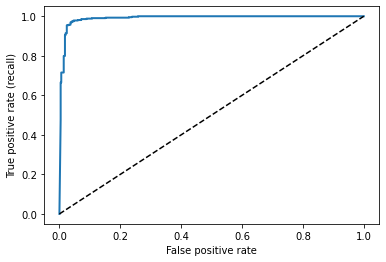

In [30]:
train_prediction_scores = bin_nb_model.predict_proba(train_X)[:, 1]
test_prediction_scores = bin_nb_model.predict_proba(test_X)[:, 1]

fpr, tpr, thresholds = roc_curve(test_y, test_prediction_scores)

gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
threshold = thresholds[ix]
test_prediction = np.asarray([ 1 if x > threshold else 0 for x in test_prediction_scores])
print("with threshold = {0} | test accuracy is {1:.2f}%"
      .format(threshold, (test_prediction==np.asarray(test_y)).mean() * 100))

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.ylabel("True positive rate (recall)")
plt.xlabel("False positive rate")

### SVM model

In [31]:
bin_svm_model = SVC(C=0.1, kernel="linear", random_state=seed)
bin_svm_model.fit(train_X, train_y)

SVC(C=0.1, kernel='linear', random_state=42)

In [32]:
train_prediction = bin_svm_model.predict(train_X)
test_prediction = bin_svm_model.predict(test_X)

train_accuracy = (train_prediction == train_y).mean() * 100
test_accuracy = (test_prediction == test_y).mean() * 100

print("train accuracy: {0:.10f}%".format(train_accuracy))
print("test accuracy: {0:.10f}%".format(test_accuracy))

train accuracy: 99.9062353493%
test accuracy: 96.6046002191%


with threshold = -0.24151935758278875 | test accuracy is 96.50%


Text(0.5, 0, 'False positive rate')

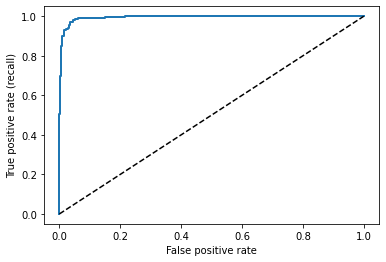

In [33]:
train_prediction_scores = bin_svm_model.decision_function(train_X)
test_prediction_scores = bin_svm_model.decision_function(test_X)

fpr, tpr, thresholds = roc_curve(test_y, test_prediction_scores)

gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
threshold = thresholds[ix]
test_prediction = np.asarray([ 1 if x > threshold else 0 for x in test_prediction_scores])
print("with threshold = {0} | test accuracy is {1:.2f}%"
      .format(threshold, (test_prediction==np.asarray(test_y)).mean() * 100))

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.ylabel("True positive rate (recall)")
plt.xlabel("False positive rate")

## Using bag of word with word counts

### Deep linear model

In [34]:
bow_train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=bow_collate)
bow_test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, collate_fn=bow_collate)

linear_model = LinearModel(n_features=vocabulary_size, n_outputs=1)
optimizer = Adam(linear_model.parameters())
loss_fn = nn.BCEWithLogitsLoss(reduction='mean')

linear_wrapper = Wrapper(linear_model, loss_fn, optimizer)

epoch: 0 | training loss: 0.28 | validation loss: 0.25
epoch: 1 | training loss: 0.14 | validation loss: 0.13
epoch: 2 | training loss: 0.08 | validation loss: 0.19
epoch: 3 | training loss: 0.07 | validation loss: 0.14
epoch: 4 | training loss: 0.06 | validation loss: 0.10
epoch: 5 | training loss: 0.06 | validation loss: 0.15
epoch: 6 | training loss: 0.08 | validation loss: 0.11
epoch: 7 | training loss: 0.08 | validation loss: 0.13
epoch: 8 | training loss: 0.07 | validation loss: 0.10
epoch: 9 | training loss: 0.05 | validation loss: 0.14
epoch: 10 | training loss: 0.05 | validation loss: 0.19
epoch: 11 | training loss: 0.05 | validation loss: 0.09
epoch: 12 | training loss: 0.05 | validation loss: 0.09
epoch: 13 | training loss: 0.04 | validation loss: 0.14
epoch: 14 | training loss: 0.04 | validation loss: 0.12
epoch: 15 | training loss: 0.04 | validation loss: 0.12
epoch: 16 | training loss: 0.03 | validation loss: 0.09
epoch: 17 | training loss: 0.03 | validation loss: 0.11
ep

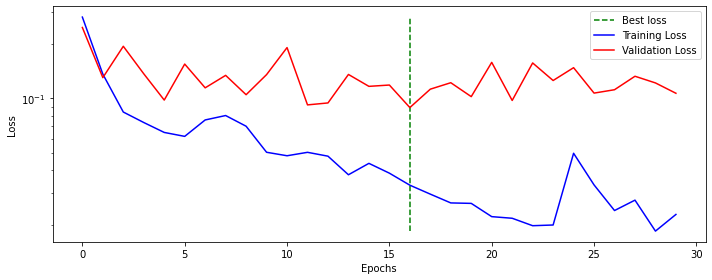

In [35]:
linear_wrapper.set_loaders(bow_train_dataloader, bow_test_dataloader)
linear_wrapper.train(n_epochs=30)
linear_wrapper.plot_losses()

threshold is 0.41521093249320984 | accuracy is 96.50%


Text(0.5, 0, 'False positive rate')

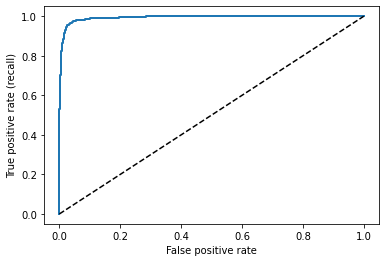

In [36]:
test_full = [bin_bow_collate([(x[0], x[1])]) for x in test_dataset]

test_prediction_scores, test_y = zip(*[(linear_wrapper.predict(x).item(), y.item()) \
                                       for x, y in list(test_full) if x.shape[0] > 0])

fpr, tpr, thresholds = roc_curve(test_y, test_prediction_scores)

gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
threshold = thresholds[ix]
test_prediction = np.asarray([ 1 if x > threshold else 0 for x in test_prediction_scores])
print("threshold is {0} | accuracy is {1:.2f}%"
      .format(threshold, (test_prediction==np.asarray(test_y)).mean() * 100))

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.ylabel("True positive rate (recall)")
plt.xlabel("False positive rate")

### Naive Bayes

In [37]:
def email_embedding(email):
    embedding = np.zeros((1, vocabulary_size))
    for word_index in email:
        if (word_index.int().item() > 0):
            embedding[0, word_index.int().item() - 1] += 1
    return embedding

In [38]:
train_full = np.asarray([np.append(email_embedding(x[0]), x[1].item()) for x in train_dataset])
train_X, train_y = train_full[:, :-1], train_full[:, -1]

test_full = np.asarray([np.append(email_embedding(x[0]), x[1].item()) for x in test_dataset])
test_X, test_y = test_full[:, :-1], test_full[:, -1]

print("train set: x {}, y {}\ntest set: x {}, y {}".format(train_X.shape, train_y.shape, test_X.shape, test_y.shape))

train set: x (2133, 5000), y (2133,)
test set: x (913, 5000), y (913,)


In [39]:
nb_model = MultinomialNB()
nb_model.fit(train_X, train_y)

MultinomialNB()

In [40]:
train_prediction = nb_model.predict(train_X)
test_prediction = nb_model.predict(test_X)

train_accuracy = (train_prediction == train_y).mean() * 100
test_accuracy = (test_prediction == test_y).mean() * 100

print("train accuracy: {0:.10f}%".format(train_accuracy))
print("test accuracy: {0:.10f}%".format(test_accuracy))

train accuracy: 98.1247069855%
test accuracy: 96.3855421687%


with threshold = 0.39088620121328443 | test accuracy is 96.82%


Text(0.5, 0, 'False positive rate')

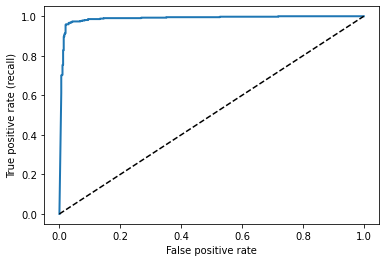

In [41]:
train_prediction_scores = nb_model.predict_proba(train_X)[:, 1]
test_prediction_scores = nb_model.predict_proba(test_X)[:, 1]

fpr, tpr, thresholds = roc_curve(test_y, test_prediction_scores)

gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
threshold = thresholds[ix]
test_prediction = np.asarray([ 1 if x > threshold else 0 for x in test_prediction_scores])
print("with threshold = {0} | test accuracy is {1:.2f}%"
      .format(threshold, (test_prediction==np.asarray(test_y)).mean() * 100))

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.ylabel("True positive rate (recall)")
plt.xlabel("False positive rate")

### SVM model

In [42]:
svm_model = SVC(C=0.1, kernel="linear", random_state=seed)
svm_model.fit(train_X, train_y)

SVC(C=0.1, kernel='linear', random_state=42)

In [43]:
train_prediction = svm_model.predict(train_X)
test_prediction = svm_model.predict(test_X)

train_accuracy = (train_prediction == train_y).mean() * 100
test_accuracy = (test_prediction == test_y).mean() * 100

print("train accuracy: {0:.10f}%".format(train_accuracy))
print("test accuracy: {0:.10f}%".format(test_accuracy))

train accuracy: 99.8593530239%
test accuracy: 95.9474260679%


with threshold = 0.1518686877576932 | test accuracy is 96.28%


Text(0.5, 0, 'False positive rate')

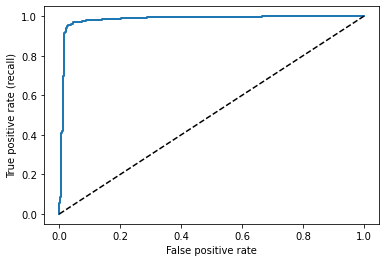

In [44]:
train_prediction_scores = svm_model.decision_function(train_X)
test_prediction_scores = svm_model.decision_function(test_X)

fpr, tpr, thresholds = roc_curve(test_y, test_prediction_scores)

gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
threshold = thresholds[ix]
test_prediction = np.asarray([ 1 if x > threshold else 0 for x in test_prediction_scores])
print("with threshold = {0} | test accuracy is {1:.2f}%"
      .format(threshold, (test_prediction==np.asarray(test_y)).mean() * 100))

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.ylabel("True positive rate (recall)")
plt.xlabel("False positive rate")